# Aeropspike Graph 101

## Air-Routes graph schema

The schema includes the following elements:

1. Airport vertex: Represents an airport in the transporation network. It has properties such as:
    1. **'code'**: The unique code assigned to the airport.
    2. **'name'**: The name of the airport.
    3. **'location'**: The geographical coordinates of the airport (latitud and longitud).
    4. **'timezone'**: The time zone of the airport.   
&nbsp;
2. Route edge: Represents a flight route between two airports. It has properties suh as:
    1. **'airline'**: The name of the airline operating the flight.
    2. **'distance'**: The distance between the airports.

--- 
### Launch the containers

    % export FEATKEY=$(base64 -i /Users/Shared/setup/as_featurekey.conf)
    % docker run -d -e "FEATURES=$FEATKEY" -e "FEATURE_KEY_FILE=env-b64:FEATURES" --name as_database -p 3000-3002:3000-3002 aerospike/aerospike-server-enterprise
    % docker run -p8182:8182 --name as_graph -v /Users/Shared/data/docker-bulk-load:/opt/aerospike/etc/sampledata -e aerospike.client.namespace="test" -e aerospike.client.host="172.17.0.2:3000" -e aerospike.graph.index.vertex.label.enabled=true aerospike/aerospike-graph-service

**Note**: The `-v` option allows you to bind a directory in your host operating system to a directory inside the Docker container. 
    
### Importing Python modules

In [1]:
from graph_fmt import *
from ipywidgets import interact
from pandas.plotting import table
from importlib.metadata import version
from IPython.display import display_markdown
from IPython.display import Markdown as md, display, HTML

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.traversal import IO
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.graph_traversal import GraphTraversalSource, __
from gremlin_python.process.traversal import Barrier, Bindings, Cardinality, Column, Direction, Operator, Order, P, Pop, Scope, T, WithOptions

import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
import nest_asyncio
import networkx as nx
import ipycytoscape
import jugri
import pandas as pd
import re

nest_asyncio.apply()
statics.load_statics(globals())

---
## 2. Connect to the Graph Service and Load the Air-Route data

In [2]:
%%time
g = traversal().withRemote(DriverRemoteConnection('ws://0.0.0.0:8182/gremlin','g'))
g.V().drop().iterate()

g.with_("evaluationTimeout", 5 * 60 * 1000)\
 .io("data/air_routes/air-routes-50k.graphml")\
 .with_(IO.reader, IO.graphml)\
 .read()\
 .toList()


CPU times: user 36.1 ms, sys: 7.81 ms, total: 44 ms
Wall time: 16.7 s


[]

<img src="../img/graphML.png" alt="Drawing" width="700" height="150"/>

### Populate the Graph (Vertices & Edges)

In [3]:
graph_stats = pd.DataFrame(g.V("~graph_summary").valueMap().toList())
dgraph_sch(graph_stats, g)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'any', 'style': {'content': '…

Display vertices and edges counts in tabular form or as a matplotlib chart.

In [4]:
v_cnt = pd.DataFrame.from_dict(g.V().label().groupCount().toList()).T   # .T to Transpose the dataframe
v_cnt.reset_index(inplace=True)
v_cnt.columns = ['vertex name','count']
e_cnt = pd.DataFrame.from_dict(g.E().label().groupCount().toList()).T   # .T to Transpose the dataframe
e_cnt.reset_index(inplace=True)
e_cnt.columns = ['edge name','count']

The cell below use **matplotlib** to display the counts as a bar chart.

## Total Number of Vertices: 3749; Total Number of Edges: 57645

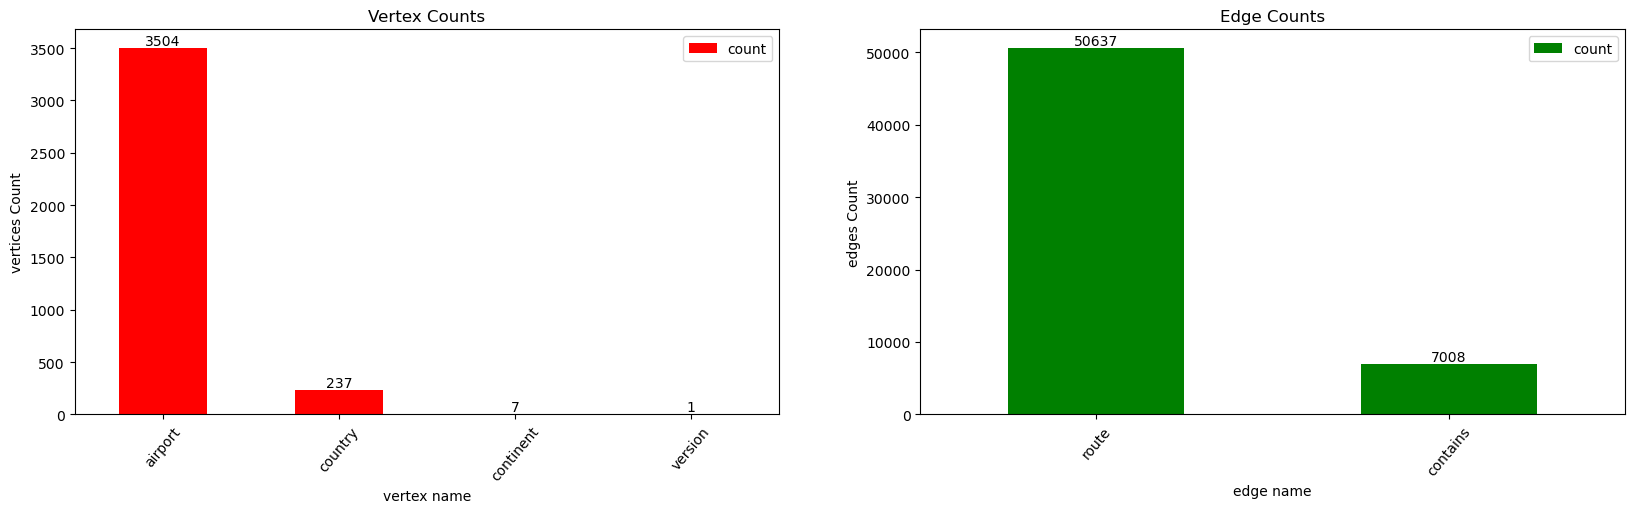

In [5]:
display_markdown(f'''## Total Number of Vertices: {v_cnt['count'].sum()}; Total Number of Edges: {e_cnt['count'].sum()}''', raw=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = v_cnt.sort_values(by = 'count', ascending=False,).plot.bar(ax=axes[0], title='Vertex Counts', x='vertex name', rot=50, color = 'red')
ax1.set_ylabel("vertices Count")
ax1.bar_label(ax1.containers[0])
ax2 = e_cnt.sort_values(by = 'count', ascending=False,).plot.bar(ax=axes[1], title='Edge Counts',x='edge name', rot=50, color = 'green')
ax2.set_ylabel("edges Count")
ax2.bar_label(ax2.containers[0])
plt.show()

---

## 3. Traverse the graph data

### Query 1: Retreive all columns for the airport with code 'AUS' (Austin)

    g.V()
     .has('code','AUS')
      .valueMap()
     .next()
     
* `g.V()`: Retrieves all the vertices in the graph.
* `.has('code','AUS')`: Filtered by vertices with code = 'AUS'.
* `.valueMap()`: projects the resault as a key value map of all the vertex properties.
* `.next()`: Returns the final result set of the query.

In [6]:
display(pd.DataFrame(g.V().has('code','AUS').valueMap().next()))

,city,code,country,desc,elev,icao,lat,lon,longest,region,runways,type
0,Austin,AUS,US,Austin Bergstrom International Airport,542,KAUS,30.1945,-97.669899,12250,US-TX,2,airport


---
### Query 2: Display a pie chart of the ten top countries with the most number of airports.

    g.V()
     .hasLabel('airport')
      .groupCount().by('country')
     .next()
     
* `.hasLabel('airport')`: Retrive all vertices with the vertex label equal to **airport**.
* `.groupCount().by('country')`: group and count all occurrances of airports by country.

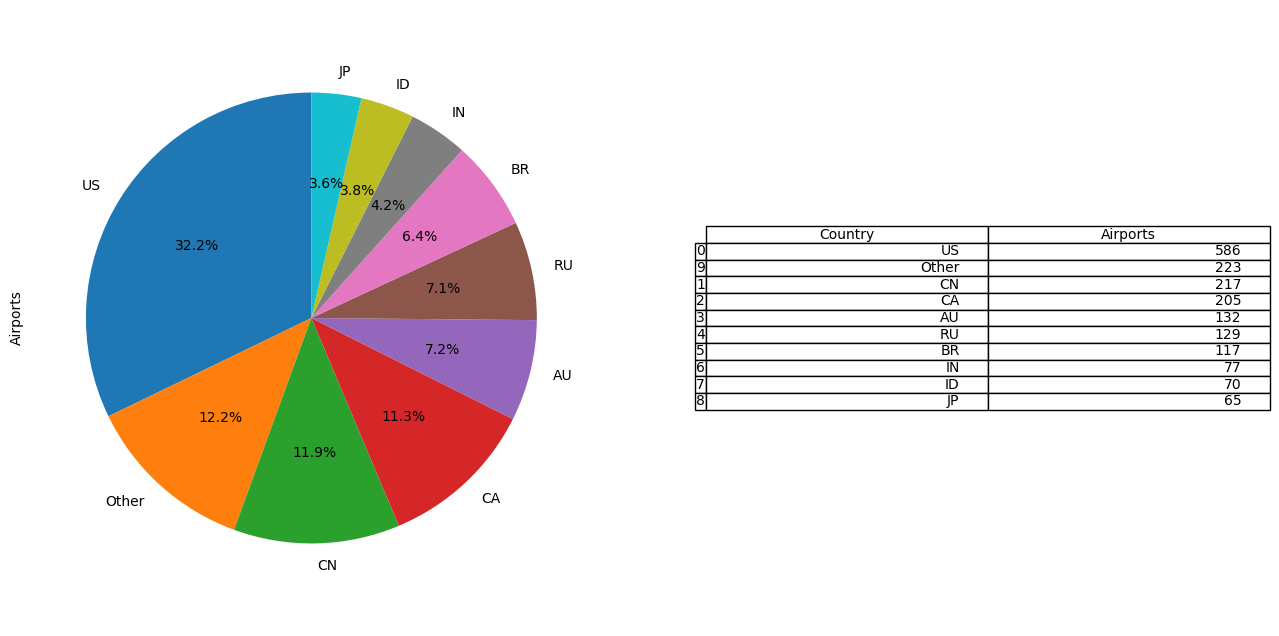

In [7]:
df = pd.DataFrame(g.V().hasLabel('airport').groupCount().by('country').next(), index=['Airports']).T
df.reset_index(inplace=True)
df.rename(columns = {'index':'Country'}, inplace = True)
srt_temp = df.sort_values(by = 'Airports', ascending=False)
not_top_ten = len(srt_temp) - 9
not_top_ten_sum = srt_temp.tail(not_top_ten).sum()
srt_top = srt_temp.head(9)
new_record = pd.DataFrame([{'Country':'Other', 'Airports':not_top_ten}])
df = pd.concat([srt_top, new_record], ignore_index=True)
df.sort_values(by = 'Airports', ascending=False, inplace=True)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
df.plot(kind='pie', y = 'Airports', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['Country'], legend = False, fontsize=10)

ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, df, loc='center')
tbl.auto_set_font_size(True)
tbl.set_fontsize(10)
plt.show()

---
### Query 3: Show possible routes from London to the San Jose with one stop.

     g.V()
      .has('airport','code','LHR')
       .out().out()
        .has('code','SJC')
        .limit(15)
       .path()
       .by('code')
      .toList()
      
* `.has('airport','code','LHR')`: Filters the vertices by those with the propery **'airport'** and value **'code'** equal to **'LHR'** (London Heathrow Airport).
* `.out().out()`: Traverses two steps out from the previous filtered vertices. This means it retrieves vertices that are connected by edges going out two times form the **'LHR'** vertex. These vertices represent flights departing from London Heathrow Airport, possibly making a stopover at another airport.
* `.has('code','SJC')`: Filters the vertices retrieved in the previous step by those with the property **'code'** equal to **'SJC'** (San Jose International Airport).
* `.limit(15)`: Limits the result to only return a maximum of 15 vertices.
* `.path().by('code')`: Retrieves the paths taken to reach the filtered vertices represented by the **'code'** property of each vertex. This means it returns the flight routes from London Heathrow Airport to San Jose International Airport.

In [8]:
display(HTML("<style>.container { width:100% !important; }</style>"))
df = pd.DataFrame(g.V().has('airport','code','LHR').out().out().has('code','SJC').limit(15).path().by('code').toList())
df.rename(columns = {df.columns[0]:'Path'}, inplace = True)
legs = pd.DataFrame(columns=['Source_Airport', 'Dest_Airport'])
df = df.astype('str')
for index, row in df.iterrows():
    s = re.search(r"path\[(.*), (.*), (.*)\]", str(row))
    legs.loc[len(legs)] = [s.group(1),s.group(2)]
    legs.loc[len(legs)] = [s.group(2), s.group(3)]
df1 = pd.DataFrame(legs['Source_Airport'].unique(), columns = ['Airport'])
df2 = pd.DataFrame(legs['Dest_Airport'].unique(), columns = ['Airport'])
vertices = pd.concat([df1, df2])
vertices = pd.DataFrame(vertices['Airport'].unique(), columns = ['Airport'])
vertices_list =[(v, {"label": v}) for v in vertices.Airport.values.tolist()]
NX_graph = nx.DiGraph()
NX_graph.add_nodes_from(vertices_list)
NX_graph.add_edges_from(legs.values.tolist())
# Display the first 5 rows only in tabular form
graph_draw = ipycytoscape.CytoscapeWidget()
graph_draw.graph.add_graph_from_networkx(NX_graph, directed=True)
graph_draw.set_style(
  [
    {
      "selector": "any",
      "style": {
        "content": "data(name)",
        "label": "data(label)",
        "font-size": "5px",
        "text-valign": "center",
        "text-halign": "center",
        "background-color": "#b20b00",
        "z-index": "10"
      }
    },
    {"selector": 'node]',
       "style": {
           "content": "data(name)",
           "label": "data(label)",
           "text-valign": "center",
           'color': 'white',
           "font-size": 10,
           "width": 30,
           "height": 30,
           "background-color": "#b20b00",
       }
    }
  ]
)
graph_draw

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'any', 'style': {'content': '…

---
### Query 4: Get geoCoordinates (latitude & longitude) and number of runways from the airpot vertex where the airpot codes.

     g.V()
      .has('code',row[0])
      .valueMap()
      .next()
      

In [9]:
tme = pd.DataFrame()
tme['airports']= legs.stack().values
tme.drop_duplicates(inplace=True)
m = folium.Map(location=[60.55, -19.01], zoom_start=3)
fg = folium.FeatureGroup(name="Runways")
m.add_child(fg)
g0 = folium.plugins.FeatureGroupSubGroup(fg, "Origin/Dest")
m.add_child(g0)
g1 = folium.plugins.FeatureGroupSubGroup(fg, "<5 Runways")
m.add_child(g1)
g2 = folium.plugins.FeatureGroupSubGroup(fg, ">=5 Runways")
m.add_child(g2)
for index, row in tme.iterrows():
    x = g.V().has('code',row[0]).valueMap().next()        ## <==== Gremlin Query
    loc = [x['lat'][0], x['lon'][0]]
    if row[0] == "SJC" or row[0] == "LHR":
        folium.Marker(loc, popup=row[0],icon=folium.Icon(color='green')).add_to(g0)
    elif x['runways'][0] < 5:
        folium.Marker(loc, popup=row[0]).add_to(g1)
    else:
        folium.Marker(loc, popup=row[0]).add_to(g2)
   
folium.LayerControl(collapsed=False).add_to(m)
m

---
### QUERY 5: Return a map where the keys are the continent codes and the values are the number of airports in that continent.

    g.V()
     .hasLabel('continent')
      .group()
       .by('code')
       .by(__.out().count())
     .next()

* `.hasLabel('continent')`: This filters the vertices to only include those with the label **'continent'**.
* `.group()`: This function groups the filtered vertices.
* `.by('code')`: This specifies that the grouping key will be **'code'** property of the verices.
* `.by(__.out().count())`: This specifies that the value for each group will be the count of outgoing edges from each vertex.

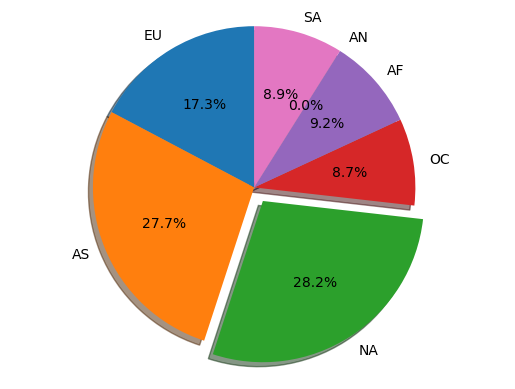

In [10]:
m = g.V().hasLabel('continent').group().by('code').by(__.out().count()).next()

fig,pie1 = plt.subplots()
pie1.pie(m.values() \
        ,labels=m.keys() \
        ,autopct='%1.1f%%'\
        ,shadow=True \
        ,startangle=90 \
        ,explode=(0,0,0.1,0,0,0,0))
pie1.axis('equal')  

plt.show()

---

### Query 6: Find the number of international and domestic flights with one stop from SFO.

    g.V()
     .has("code", "SFO")
      .out().out()
       .dedup()
       .fold()
     .project("International Flights From SFO", "Domestic Flights From SFO")
      .by(__.unfold().count())
      .by(__.unfold()
       .has("country", "US")
       .count())
     .next()
     
 * `.dedup()`: Use the dedup step to remove duplicates from a result.
 * `.fold()`: Gathers all elements in the stream to that point and reduces them to a List.
 * `.unfold()`: Does the opposite, taking a List and unrolling it to its individual items and placing each back in the stream.
 * `.project()`: Is similar to SQL project, that is, which properties we want to pick for display.

In [11]:
display_markdown(f''' ### {
g.V().has("code", "SFO").out().out().dedup().fold().project("International Flights From SFO", "Domestic Flights From SFO").by(__.unfold().count()).by(__.unfold().has("country", "US").count()).next()
}''', raw=True)

 ### {'International Flights From SFO': 1904, 'Domestic Flights From SFO': 455}